### Import das bibliotecas utilizadas

In [87]:
import pandas as pd
import numpy as np
from   sklearn.model_selection import train_test_split
from   sklearn.metrics import accuracy_score
from   sklearn.preprocessing import StandardScaler
from   sklearn import svm
from   sklearn.svm import SVC
from   sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from joblib import load
import os 

### Seleciona acelX, acelY, acelZ e atividade

In [91]:
dfs = []

base_path = "C:\\classificador-de-padroes-de-mobilidade\\dataset\\raw\\Dataset-FallWatch"
for i in range(1,6):
    folder_name_avd = f"U{i:02d}\\AVD's"
    folder_name_fall = f"U{i:02d}\\Falls"
    
    folder_path_avd = os.path.join(base_path, folder_name_avd)
    folder_path_fall = os.path.join(base_path, folder_name_fall)
    
    for j in range(1, 12):
        file_name_avd = f'U{i:02d} - D{j:02d}.csv'
        file_path_avd = os.path.join(folder_path_avd, file_name_avd)
        
        file_name_fall = f'U{i:02d} - F{j:02d}.csv'
        file_path_fall = os.path.join(folder_path_fall, file_name_fall)
        
        if os.path.exists(file_path_avd):
            df = pd.read_csv(file_path_avd)
            df['idTipoMovimento'] = f'D{j:02d}'
            dfs.append(df)
            
        if os.path.exists(file_path_fall):
            df = pd.read_csv(file_path_fall)
            df['idTipoMovimento'] = f'F{j:02d}'
            dfs.append(df)

dataframe = pd.concat(dfs, ignore_index=True)

movimentos_formatados = {"D01":"Caminhando",
"D02":"Correndo",
"D03":"Subindo e descendo escadas",
"D04":"Sentando em uma cadeira, esperar um momento e levantar-se",
"D05":"Sentado por um momento, tentar levantar-se e cair na cadeira",
"D06":"Agachando (dobrando os joelhos), amarrar sapatos e levantar-se",
"D07":"Tropeçar enquanto caminha",
"D08":"Pular suavemente sem cair(tentando alcançar um objeto)",
"D09":"Bater na mesa com a mão",
"D10":"Batendo palmas",
"F01":"Queda para frente ao caminhar causada por escorregão",
"F02":"Queda lateral ao caminhar causada por escorregão",
"F03":"Queda para trás ao caminhar causada por escorregão",
"F04":"Queda para frente ao caminhar causada por tropeço",
"F05":"Queda para trás ao tentar sentar-se",
"F06":"Queda para frente enquanto sentado, causada por desmaio ou adormecimento",
"F07":"Queda para trás enquanto sentado, causada por desmaio ou adormecimento",
"F08":"Queda lateral enquanto sentado, causada por desmaio ou adormecimento",
}

colunas_selecionadas = ['acelX', 'acelY', 'acelZ' ,'idTipoMovimento']
dataframe = dataframe[colunas_selecionadas]
dataframe['MAGNITUDE_ACEL']   = np.sqrt(dataframe['acelX']**2 + dataframe['acelY']**2 + dataframe['acelZ']**2)
dataframe = dataframe[dataframe['idTipoMovimento'].isin(['D01', 'D02', 'F01'])]

array(['D01', 'F01', 'D02'], dtype=object)

### Mensura volume do dataset

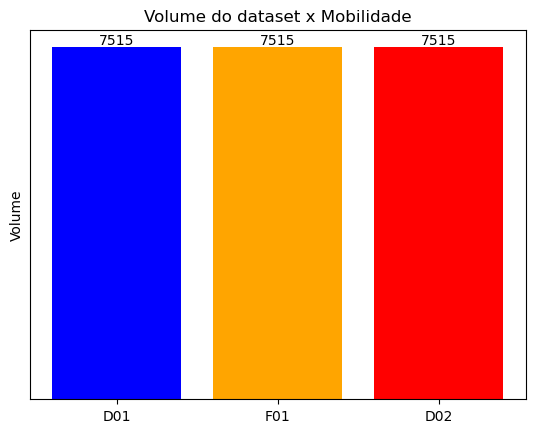

In [89]:
eixo_x = dataframe['idTipoMovimento'].unique()
contagem = len(dataframe)
cores_barras = ['blue','orange','red']

fig, ax = plt.subplots()

bar_container = ax.bar(eixo_x, contagem, color=cores_barras)
ax.bar_label(bar_container, fmt='{:.0f}')
ax.set_title('Volume do dataset x Mobilidade')
# ax.set_xlabel('Mobilidade')
ax.set_ylabel('Volume')
# ax.legend()
plt.yticks([]) # Remover escala do eixo y
plt.xticks(eixo_x)
# plt.savefig('C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\volume_dataset_por_mobilidade.png')
plt.show()

### Treinamendo do teste do modelo (todas as mobilidades)

[[179  27 306]
 [ 78 370  64]
 [ 34  16 429]]
              precision    recall  f1-score   support

         D01       0.62      0.35      0.45       512
         D02       0.90      0.72      0.80       512
         F01       0.54      0.90      0.67       479

    accuracy                           0.65      1503
   macro avg       0.68      0.66      0.64      1503
weighted avg       0.69      0.65      0.64      1503



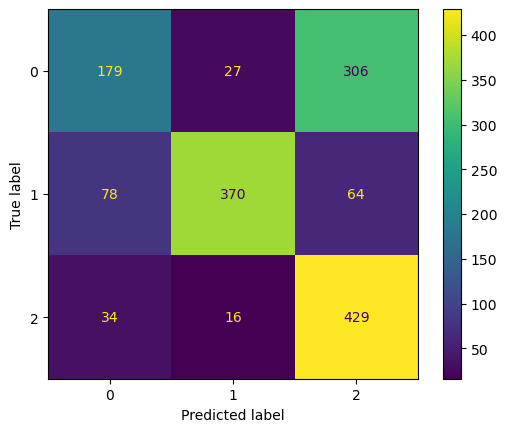

In [114]:
X_train, X_test, y_train, y_test = train_test_split(dataframe[['MAGNITUDE_ACEL']], dataframe['idTipoMovimento'], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = SVC(kernel='rbf')  
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig('C:\\classificador-de-padroes-de-mobilidade\\results\\graphs\\svm_matriz_todos_os_movimentos.png', dpi=300, bbox_inches='tight')

with open('modelos/svm_model.joblib', 'wb') as file:
    dump(model, file)

In [115]:
df_teste_modelo = dataframe[dataframe['idTipoMovimento'].isin(['F01'])]
df_teste_modelo = df_teste_modelo.drop(columns=['acelX','acelY','acelZ','idTipoMovimento'])
    
with open('modelos/svm_model.joblib', 'rb') as file:
    svm_loaded = load(file)
    
X_test = df_teste_modelo

y_pred = svm_loaded.predict(X_test)

print("Previsões: ", y_pred)

# with open('predicoes/svm_predicoes.txt', 'w') as f:
#     for pred in y_pred:
#         f.write(f"{pred}\n")

# print("Previsões salvas no arquivo 'predicoes/svm_predicoes.txt'")

c:\Users\julia\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Previsões:  ['D02' 'D02' 'D02' ... 'D02' 'D02' 'D02']
